In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
path_to_dataset = '/content/gdrive/My Drive/IR/icdar2019'

Mounted at /content/gdrive


In [2]:
!pip install transformers
%matplotlib inline

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 40.5 MB/s 
     |████████████████████████████████| 3.3 MB 41.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np
import pandas as pd
import re
import plotly.express as px
import pickle
import torch
import string
import nltk.data
import glob
import os
from os import path
import plotly.express as px
import editdistance
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import seaborn as sns

In [4]:
nltk.download('punkt')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
def get_spaceids(sentence, gold_standard_sentence):
    ocr_ids = [match.span()[0] for match in re.finditer(" ", sentence)]
    gold_standard_ids = [match.span()[0] for match in re.finditer(" ", gold_standard_sentence)]

    cursor = 0
    found = []

    for i, id in enumerate(ocr_ids):
        while cursor < len(gold_standard_ids) and gold_standard_ids[cursor] < id:
            cursor += 1

        if cursor < len(gold_standard_ids) and gold_standard_ids[cursor] == id:
            found.append(id)
    
    found.append(len(sentence))
    
    return found

In [6]:
def create_dataset(files, is_test=False):
    aligned_words = []
    words = []
    aligned_gs_words = []
    labels = []

    total_files = len(files)
    print("Total files {}".format(total_files))

    t = ''
    
    for file in files:
        print("Processing {}".format(file))
        with open(file, "r", encoding="utf-8") as f:
            raw_text = f.readlines()

        aligned_ocr = raw_text[1][14:] if is_test == False else raw_text[1][14:-1]
        aligned_gs = raw_text[2][14:]

        file_aligned_words = []
        file_words = []
        file_aligned_gs_words = []
        file_labels = []
        
        sentence_spans = sentence_tokenizer.span_tokenize(aligned_ocr)
        
        for sentence_start, sentence_end in sentence_spans:
            sentence = aligned_ocr[sentence_start:sentence_end]
            gs_sentence = aligned_gs[sentence_start:sentence_end]
            
            sentence_aligned_words = []
            sentence_aligned_gs_words = []
            sentence_words = []
            sentence_labels = []

            new_ocr_space_ids = get_spaceids(sentence, gs_sentence)
            
            word_start = 0
            for space_id in new_ocr_space_ids:
                word = sentence[word_start:space_id]

                if len(word) == 0:
                    word_start = space_id + 1 
                    continue
                
                trimmed_word = word.replace("@", "")
                gs_word = gs_sentence[word_start:space_id]

                label = 0
                if word != gs_word:
                  label = 1
                
                sentence_labels.append(label)
                sentence_aligned_words.append(word)
                sentence_words.append(trimmed_word)
                sentence_aligned_gs_words.append(gs_word) 

                t += word
                t += gs_word
                
                word_start = space_id + 1
                
            file_aligned_words.append(sentence_aligned_words)
            file_words.append(sentence_words)
            
            file_aligned_gs_words.append(sentence_aligned_gs_words)
            file_labels.append(sentence_labels)
        
        aligned_words.extend(file_aligned_words)
        words.extend(file_words)
        aligned_gs_words.extend(file_aligned_gs_words)
        labels.extend(file_labels)
    
    print("total chars {}".format(len(t)))
    return aligned_words, words, aligned_gs_words, labels

In [7]:
def clean_up(word):
  word = re.sub(r'\n', '', word)
  word = word.lower()
  return word.strip()

def create_dataset_for_correction(file_name, df, labels):
  f = open(file_name, "w", encoding="utf-8")
  f.write('OCR,GS\n')

  total = 0
  wrong = 0

  i = 0
  for index, row in df.iterrows():
    for word, label, gs_word in zip(row['ocr_sentence'], labels[i], row['gs_sentence']):
        total = total + 1
        if label == 1 and len(clean_up(word)) > 0 and len(clean_up(gs_word)) > 0:
            f.write(word + '\n')
            f.write(gs_word + '\n')
            wrong = wrong + 1

    i = i + 1

  print("Total words: {}".format(total))
  print("Words with mistakes: {}".format(wrong))
  print("File {} is completed and saved.".format(file_name))

In [8]:
train_files = glob.glob(path_to_dataset + "/training/BG/*.txt")
aligned_words, words, aligned_gs_words, labels = create_dataset(train_files)

Total files 149
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/93.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/24.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/56.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/147.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/74.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/99.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/57.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/73.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/116.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/44.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/87.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/137.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/49.txt
Processing /content/gdrive/My Drive/IR/icdar2019/training/BG/134.txt
Processing /content/gdrive/M

In [9]:
# Check some sample sentences;
sent_stat = pd.DataFrame(
    {
        "ocr_sentence": aligned_words, 
        "gs_sentence": aligned_gs_words
    }
)

sent_stat.head()

,ocr_sentence,gs_sentence
0,"[@—, 380, —, добъръ, траждаиинъ;, не, прави, г...","[ , 380, , добъръ, гражданинъ;, не, прави, г..."
1,"[Историята,, ви, дава, да, вйдимъ,, че, учение...","[Историята@, ни, дава, да, видимъ,, че, учение..."
2,"[ШкоЛно, въсинтаине, и, учение,, и, знанието, ...","[Школно, въспитаиие, и, учение,, и, знанието, ..."
3,"[Нито, бихъ, взелъ, на, себе, си, да, твърди,,...","[Нито, бихъ, взелъ, на, себе, си, да, твърдѭ,,..."
4,"[Бжркъ, е, рЬклъ:, «Какво, е, образованието, н...","[Бѫркъ, е, рѣклъ:, «Какво, е, образованието, н..."


In [10]:
MAXIMUM_AVERAGE_LEVENSHTEIN_DISTANCE_RATE = 0.4

In [11]:
def compute_sentence_levenhstein_distance(x):
    '''Compute sentence levenshtein distance normalized by the length of the sentence'''
    ocr_sent = ''.join(x['ocr_sentence'])
    gs_sent = ''.join(x['gs_sentence'])
    return editdistance.distance(ocr_sent, gs_sent) / max(len(ocr_sent), len(gs_sent))

In [12]:
sent_stat["sent_levenshtein_distance"] = sent_stat.apply(compute_sentence_levenhstein_distance, axis=1)

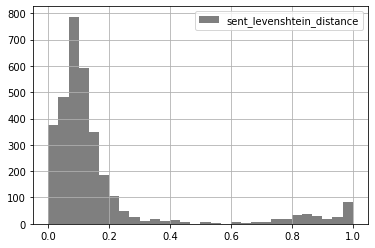

In [13]:
sent_stat["sent_levenshtein_distance"].hist(color="k", alpha=0.5, bins=30, legend=True);

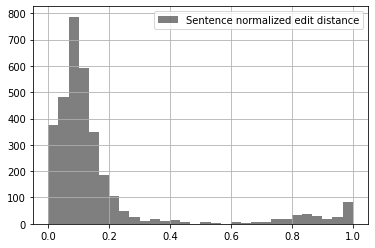

In [14]:
sent_stat["Sentence normalized edit distance"] = sent_stat["sent_levenshtein_distance"]
sent_stat["Sentence normalized edit distance"].hist(color="k", alpha=0.5, bins=30, legend=True);

In [15]:
# Remove sentences with normalized Levenshtein distance above 0.4
total_sent = sent_stat.shape[0]
good_sent = (sent_stat["sent_levenshtein_distance"] <= MAXIMUM_AVERAGE_LEVENSHTEIN_DISTANCE_RATE).sum()
print("Good sentences: %s\ntotal sentences: %s" % (good_sent, total_sent))

Good sentences: 2999
total sentences: 3317


In [16]:
good_sentences_stat = sent_stat[sent_stat["sent_levenshtein_distance"] <= MAXIMUM_AVERAGE_LEVENSHTEIN_DISTANCE_RATE]
i = random.randint(0, good_sentences_stat.shape[0] - 1)
pd.set_option("max_rows", None)

good_sentences_stat[::40].sort_values("sent_levenshtein_distance", ascending=False)

,ocr_sentence,gs_sentence,sent_levenshtein_distance,Sentence normalized edit distance
2087,[Позор»ь!],[ озор@ъ!],0.375000,0.375000
354,"[ДвЪте, не, съмъ, на, полето,, Ннто, птица, вт...","[Цвѣте, не, съмъ, на, полето,, Нито, птица, въ...",0.290698,0.290698
3277,"[Дб, ся, с:га, да, в, 1дить,, какъ, той, улЬ, ...","[Дѣ, с , с га, да, в, @дишь,, какъ, той, умѣ, ...",0.239130,0.239130
874,"[К.хдВ, се, 66, дВн*ла, онази, хубость,, кояго...","[К@ѫдѣ, се, бѣ, дѣнѫла, онази, хубость,, кояго...",0.214286,0.214286
1913,"[А, гжскитЪ,, кокошкнгЬ, се, раз-, шумЪхж,, ра...","[А, гѫскитѣ,, кокошкитѣ, се, раз‑, шумѣхѫ,, ра...",0.209877,0.209877
1040,"[Той, помолил и, ония,, които, му, свързали, р...","[Той, помолил@ъ, ония,, които, му, свързали, р...",0.202020,0.202020
2924,"[Вече, женнтЪ, сь, дечур@, лигата, б'Ьхж, изле...","[Вече, женитѣ, съ, дѣчур‑, лигата, б@ѣхѫ, излѣ...",0.196429,0.196429
537,"[Безъ, съмнЬние,, Агриииа, го, е, наклЪветнлъ,...","[Безъ, съмнѣние,, Агрип а, го, е, наклѣветилъ,...",0.196078,0.196078
3152,"[ЗабЬлВпаната, огь, тебъ, жертва, трВбва, да, ...","[Забѣлѣ аната, отъ, тебь, жертва, трѣбва, да, ...",0.193333,0.193333
2797,"[.Дикургъ, ввелъ, въ, Сиарта, гианасти--.]","[@Дикургъ, ввелъ, въ, Спарта, гимнасти@@‑]",0.187500,0.187500


In [17]:
bad_sentences = sent_stat[sent_stat["sent_levenshtein_distance"] > MAXIMUM_AVERAGE_LEVENSHTEIN_DISTANCE_RATE]
i = random.randint(0, bad_sentences.shape[0] - 1)

bad_sentences[i: i + 20].sort_values("sent_levenshtein_distance", ascending=False)

,ocr_sentence,gs_sentence,sent_levenshtein_distance,Sentence normalized edit distance
514,"[„Какво, @@@@общо, @@@@@@@@има, @@@между, @@бо...","[pas en, peine de, dissimuler,, recevait, sur ...",1.000000,1.000000
517,"[@Казаците, @@@@пустнали.]","[le Czar. , Votre Majesté]",1.000000,1.000000
515,"[@Това, се, @@@@случило, @@по, @@@@сетне.]","[foule, et, demandait à, tout, moment: où]",1.000000,1.000000
516,"[2$), @@@@Една, @пощь, @@@@@@Карлъ, @като, @ог...","[est, donc mon, frère, Charles?..,, Alors, pre...",0.995434,0.995434
518,"[@@подпре, @@му, @@@@@три, @вистрела, @@@@@и, ...","[est donc, bien, ingrate,, reprit le, comte,, ...",0.984848,0.984848
525,"[Допс, топ, йегв, СИатТез?..,, А1отз, ргепап!]","[тнѣ., 29), Една, @ ощь Карлъ, @като, ог@лежд]",0.941176,0.941176
681,"[@Смъ@ртьта, @на Лаура.]","[Катъ птици, мили Мисли]",0.900000,0.900000
528,"[1е Сгат.—■, Уо1то Ма)ез1е, сз!]","[@@@ѫка@.@@, @@@@Каза@цитѣ, пус]",0.884615,0.884615
530,"[тайгайе, зез, тайгез.]","[ра@нили, @въ, @крака.]",0.882353,0.882353
529,"[Допс, Ъшп пщга1е,, гергй, 1е сот!е, сГауотг, ...","[нали, @@подирѣ му, @тр@и, @вис@трѣла и люто, ...",0.878049,0.878049


In [18]:
words = np.array(words)[good_sentences_stat.index.tolist()].tolist()
aligned_gs_words = np.array(aligned_gs_words)[good_sentences_stat.index.tolist()].tolist()
labels = np.array(labels)[good_sentences_stat.index.tolist()].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [19]:
print("Example of good words {}".format(words[:1]))
print("Example of the gold standard equivalent of the good words {}".format(aligned_gs_words[:1]))
print("With labels: {}".format(labels[:1]))

Example of good words [['—', '380', '—', 'добъръ', 'траждаиинъ;', 'не', 'прави', 'го', 'и', 'добъръ', 'человйкъ.']]
Example of the gold standard equivalent of the good words [['  ', '380', ' ', 'добъръ', 'гражданинъ;', 'не', 'прави', 'го', 'и', 'добъръ', 'человѣкъ.']]
With labels: [[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]]


Total files 49
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/17.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/44.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/14.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/15.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/46.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/38.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/8.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/5.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/33.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/31.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/21.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/40.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/35.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/20.txt
Processing /content/gdrive/My Drive/IR/icdar2019/test/BG/24.txt
Processing /content/gdrive/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



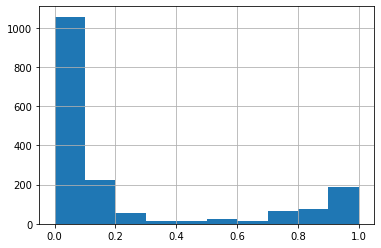

In [20]:
test_files = glob.glob(path_to_dataset + "/test/BG/*.txt")

test_aligned_words, test_words_ocr, test_aligned_gs_words, test_labels = create_dataset(test_files, is_test=True)
test_sent_stat = pd.DataFrame({
      "ocr_sentence": test_aligned_words, 
      "gs_sentence": test_aligned_gs_words
    })

test_sent_stat["sent_levenshtein_distance"] = test_sent_stat.apply(compute_sentence_levenhstein_distance, axis=1)
test_sent_stat["sent_levenshtein_distance"].hist()

print("good sentences: %s\ntotal sentences: %s" % ((test_sent_stat["sent_levenshtein_distance"] <= MAXIMUM_AVERAGE_LEVENSHTEIN_DISTANCE_RATE).sum(), test_sent_stat.shape[0]))
test_good_sentences_stat = test_sent_stat[test_sent_stat["sent_levenshtein_distance"] <= MAXIMUM_AVERAGE_LEVENSHTEIN_DISTANCE_RATE]

test_words = np.array(test_words_ocr)[test_good_sentences_stat.index.tolist()].tolist()
test_labels = np.array(test_labels)[test_good_sentences_stat.index.tolist()].tolist()

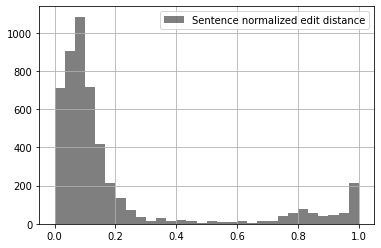

In [21]:
sent_stat["Sentence normalized edit distance"] = sent_stat["sent_levenshtein_distance"]
test_sent_stat["Sentence normalized edit distance"] = test_sent_stat["sent_levenshtein_distance"]

sth =  pd.concat([sent_stat["Sentence normalized edit distance"], test_sent_stat["Sentence normalized edit distance"]])

f11=pd.concat([sent_stat["Sentence normalized edit distance"], test_sent_stat["Sentence normalized edit distance"]])
sth.hist(color="k", alpha=0.5, bins=30, legend=True);

In [22]:
create_dataset_for_correction("/content/correct_train.txt", good_sentences_stat, labels)
create_dataset_for_correction("/content/correct_test.txt", test_good_sentences_stat, test_labels)

Total words: 43716
Words with mistakes: 14245
File /content/correct_train.txt is completed and saved.
Total words: 24825
Words with mistakes: 6404
File /content/correct_test.txt is completed and saved.


In [23]:
pos_labels_count = sum(sum(sent_labels) for sent_labels in labels)
total_labels_count = sum(len(sent_labels) for sent_labels in labels)
print("Incorrect words: {}, total: {}".format(pos_labels_count, total_labels_count))

Incorrect words: 14651, total: 43716


In [24]:
MAX_SEQUENCE_LENGTH = 100

In [25]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [26]:
def tokenize_bert(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        number_of_subtokens = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * number_of_subtokens)

    tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"]
    labels = [0] + labels + [0]
    
    return tokenized_sentence, labels

In [27]:
def truncate_or_pad(arr, max_sequence_length):   
    return arr[:max_sequence_length] + [tokenizer.pad_token_id] * (max_sequence_length - len(arr))

In [28]:
def prepare_dataset(words, labels, max_sequence_length=100):
    tokenized_texts_and_labels = [tokenize_bert(sentence, lbls) for sentence, lbls in zip(words, labels)]

    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    tokenized_labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
    input_ids = np.array([truncate_or_pad(tokenizer.convert_tokens_to_ids(txt), max_sequence_length) for txt in tokenized_texts], dtype='long')
    subtoken_labels = np.array([truncate_or_pad(sentence_labels, max_sequence_length) for sentence_labels in tokenized_labels], dtype='long')
    attention_masks = [[int(x != 0) for x in y] for y in input_ids]

    inputs = torch.tensor(input_ids, dtype=torch.long)
    tags = torch.tensor(subtoken_labels, dtype=torch.long)
    masks = torch.tensor(attention_masks, dtype=torch.long)
    return inputs, tags, masks

MAX_SEQUENCE_LENGTH = 100
train_inputs, train_tags, train_masks = prepare_dataset(words, labels, MAX_SEQUENCE_LENGTH)

In [29]:
test_inputs, test_tags, test_masks = prepare_dataset(test_words, test_labels, MAX_SEQUENCE_LENGTH)

In [30]:
class CNNModel(nn.Module):
    def __init__(self, hidden_dropout_prob):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5
        self.embedding_dim = 768
        self.out_size = 32
        self.num_labels = 2
        
        self.conv_1 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_1, stride=1, padding=1)
        self.pool_1 = nn.MaxPool1d(kernel_size=self.kernel_1, stride=1)
        self.conv_2 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_2, stride=1, padding=1)
        self.pool_2 = nn.MaxPool1d(kernel_size=self.kernel_2, stride=1, padding=1)
        self.conv_3 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_3, stride=1, padding=2)
        self.pool_3 = nn.MaxPool1d(kernel_size=self.kernel_3, stride=1, padding=1)
        self.conv_4 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_4, stride=1, padding=2)
        self.pool_4 = nn.MaxPool1d(kernel_size=self.kernel_4, stride=1, padding=2)
        self.classifier = nn.Linear(self.out_size * 4, self.num_labels)
    
    def forward(self, input, attention_mask):
        outputs = self.bert(input, attention_mask)
        sequence_output = outputs[0]
        conv_input = sequence_output.permute(0, 2, 1)
        conv_output_1 = self.conv_1(conv_input)
        conv_output_1 = torch.relu(conv_output_1)
        pool_output_1 = self.pool_1(conv_output_1)
        conv_output_2 = self.conv_2(conv_input)
        conv_output_2 = torch.relu(conv_output_2)
        pool_output_2 = self.pool_2(conv_output_2)
        conv_output_3 = self.conv_3(conv_input)
        conv_output_3 = torch.relu(conv_output_3)
        pool_output_3 = self.pool_3(conv_output_3)
        conv_output_4 = self.conv_4(conv_input)
        conv_output_4 = torch.relu(conv_output_4)
        pool_output_4 = self.pool_4(conv_output_4)
        conc_pool_output = torch.cat((pool_output_1, pool_output_2, pool_output_3, pool_output_4), 1)
        conc_pool_output = conc_pool_output.permute(0, 2, 1)
        sequence_output = self.dropout(conc_pool_output)
        logits = self.classifier(sequence_output) 
        return logits

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Available device: {}".format(device))

Available device: cuda


In [32]:
BATCH_SIZE = 32
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, pin_memory=True, num_workers=2, sampler=train_sampler, batch_size=BATCH_SIZE)

In [33]:
test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [34]:
model = CNNModel(0.1)
model.to(device)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CNNModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [35]:
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if "bias" in n],
        'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if "bias" not in n],
        'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [36]:
epochs = 4
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_values = []
training_acc_values = []
f1_score_values = []

all_predictions = []
all_true_labels = []
all_masks = []

for epoch in range(epochs):
    print("Running epoch: {}".format(epoch))
    model.train()
    total_loss = 0
    true_labels = []
    logits_list = []
    label_ids_list = []

    for step, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        logits = model(b_input_ids, attention_mask=b_input_mask)
        loss_fct = nn.CrossEntropyLoss()
        active_loss = b_input_mask.view(-1) == 1
        active_logits = logits.view(-1, model.num_labels)
        active_labels = torch.where(
            active_loss, b_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(b_labels)
        )
        loss = loss_fct(active_logits, active_labels)
        
        logits = logits.detach()
        logits_list.append(logits)
        true_labels.extend(b_labels)

        loss.backward()

        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        optimizer.step()
        scheduler.step()

    
    predictions = [list(p) for logits in logits_list for p in np.argmax(logits.to("cpu").numpy(), axis=2)]
    true_labels = [tl.to("cpu").numpy() for tl in true_labels]
    
    avg_train_loss = total_loss / len(train_dataloader)
    print("Training loss: {}".format(avg_train_loss))

    b_input_mask_list = b_input_mask.cpu().numpy().tolist()
    pred_tags = [p_i for p, l, a in zip(predictions, true_labels, b_input_mask_list) for p_i, l_i, a_i in zip(p, l, a) if a_i]
    valid_tags = [l_i for l, a in zip(true_labels, b_input_mask_list) for l_i, a_i in zip(l, a) if a_i]

    acc_train = accuracy_score(pred_tags, valid_tags)
    f1_score_train = f1_score(pred_tags, valid_tags)
    print("Training Accuracy: {}".format(acc_train))
    print("F1 score: {}".format(f1_score_train))

    training_acc_values.append(acc_train)
    loss_values.append(avg_train_loss)
    f1_score_values.append(f1_score_train)

    all_predictions.append(predictions)
    all_true_labels.append(true_labels)
    all_masks.append(b_input_mask_list)

Running epoch: 0


  0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)

100%|██████████| 94/94 [01:36<00:00,  1.03s/it]


Training loss: 0.45854707696336383
Training Accuracy: 0.38873239436619716
F1 score: 0.4005524861878453
Running epoch: 1


100%|██████████| 94/94 [01:38<00:00,  1.04s/it]


Training loss: 0.3027051666632612
Training Accuracy: 0.8498985801217038
F1 score: 0.7516778523489933
Running epoch: 2


100%|██████████| 94/94 [01:38<00:00,  1.05s/it]


Training loss: 0.23738958670737895
Training Accuracy: 0.884828349944629
F1 score: 0.7868852459016393
Running epoch: 3


100%|██████████| 94/94 [01:38<00:00,  1.05s/it]


Training loss: 0.197314201992877
Training Accuracy: 0.8581818181818182
F1 score: 0.7505330490405117


In [37]:
def evaluate(model_to_eval):
  model_to_eval.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  predictions, true_labels = [], []
  for batch in test_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
          logits = model_to_eval(b_input_ids, b_input_mask)
      label_ids = b_labels.to('cpu').numpy()

      loss_fct = nn.CrossEntropyLoss()
      active_loss = b_input_mask.view(-1) == 1
      active_logits = logits.view(-1, model_to_eval.num_labels)
      active_labels = torch.where(active_loss, b_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(b_labels))
      loss = loss_fct(active_logits, active_labels).item()

      eval_loss += loss
      logits = logits.detach().cpu().numpy()
      predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
      true_labels.extend(label_ids)

  eval_loss = eval_loss / len(test_dataloader)
  print("Test loss: {}".format(eval_loss))
  b_input_mask_list = b_input_mask.cpu().numpy().tolist()
  pred_tags = [p_i for p, l, a in zip(predictions, true_labels, b_input_mask_list) for p_i, l_i, a_i in zip(p, l, a) if a_i]
  valid_tags = [l_i for l, a in zip(true_labels, b_input_mask_list) for l_i, a_i in zip(l, a) if a_i]
  test_acc = accuracy_score(pred_tags, valid_tags)
  test_f1_score = f1_score(pred_tags, valid_tags)

  print("Test accuracy is: {}".format(test_acc))
  print("Test F1 score is: {}".format(test_f1_score))

In [38]:
evaluate(model)

Test loss: 0.3422766282807949
Test accuracy is: 0.9747899159663865
Test F1 score is: 0.7777777777777778


In [39]:
tokenizer_output_directory = path_to_dataset + '/bert_detection_1'
model_output_directory = tokenizer_output_directory + '/model'

if not os.path.exists(model_output_directory):
  os.makedirs(model_output_directory)

In [40]:
# Save the model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     }, 
#     model_output_directory + '/best_bert')

# tokenizer.save_pretrained(tokenizer_output_directory)

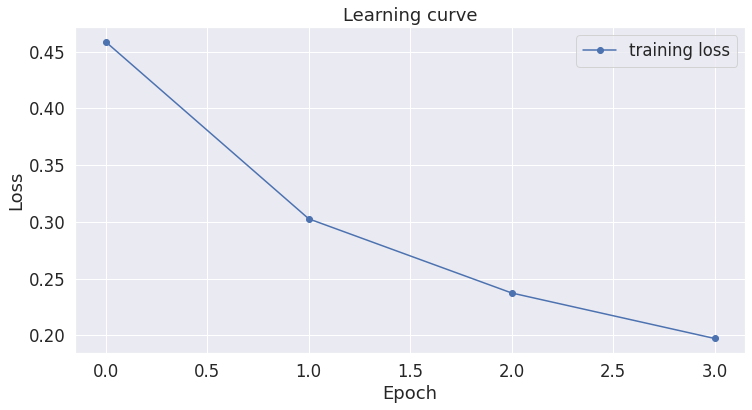

In [41]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o', label="training loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

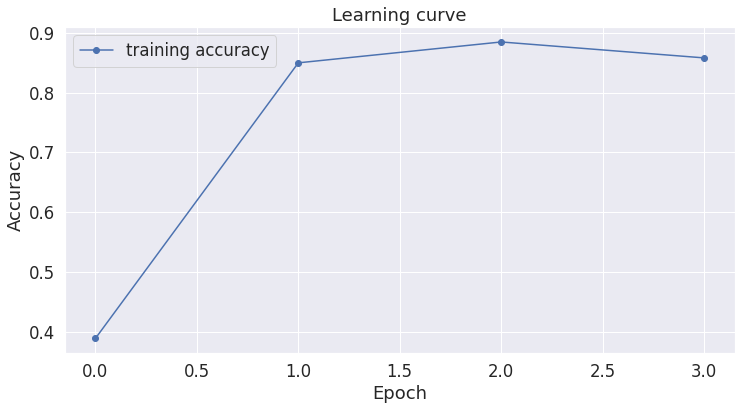

In [42]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(training_acc_values, 'b-o', label="training accuracy")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

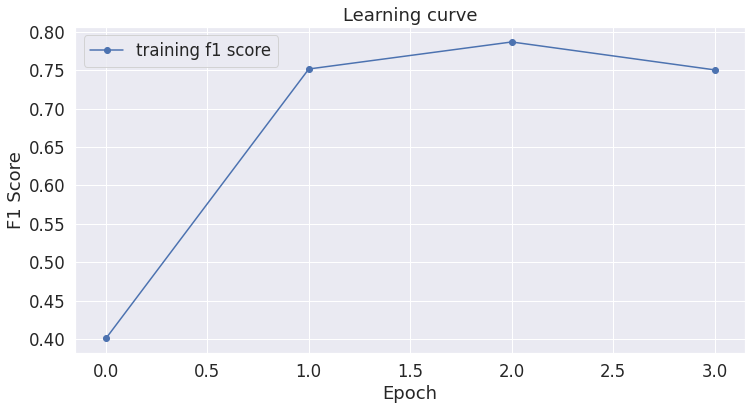

In [43]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(f1_score_values, 'b-o', label="training f1 score")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.show()

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device: {}".format(device))

tokenizer1 = BertTokenizer.from_pretrained(tokenizer_output_directory)

model1 = CNNModel(0.1)
checkpoint = torch.load(model_output_directory + '/best_bert')
model1.load_state_dict(checkpoint['model_state_dict'])
model1.to(device)

Available device: cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CNNModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [45]:
evaluate(model1)

Test loss: 0.35521332573058995
Test accuracy is: 0.9789915966386554
Test F1 score is: 0.8214285714285715


In [46]:
test_sentence = """Простодушна и хубава бе тя и азъ обичахъ да ьъ пр@е срещала но ливадите на нейното село, гдТто моите занятия ие често завеждах*."""
# test_sentence = """Реката бе край гората."""

In [47]:
def inference(test_sentence):
    tokenized_sentence = tokenizer1.encode(test_sentence)
    attention_mask = np.zeros(100)
    attention_mask[:len(tokenized_sentence)] = 1
    tokenized_sentence += [0] * (100 - len(tokenized_sentence))
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    attention_mask = torch.tensor([attention_mask]).cuda()

    with torch.no_grad():
        logits = model1(input_ids, attention_mask)
    label_indices = np.argmax(logits.to('cpu').numpy(), axis=2)

    tokens = tokenizer1.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
            if not new_labels[-1] and label_idx:
                new_labels[-1] = label_idx
        else:
            new_labels.append(label_idx)
            new_tokens.append(token)

    for token, label in zip(new_tokens, new_labels):
        if token == "[PAD]" or token in string.punctuation:
            continue
        label = 'Correct  ' if label == 0 else 'Incorrect'
        print("{}\t\t{}".format(label, token))

inference(test_sentence)

Correct  		[CLS]
Correct  		Простодушна
Correct  		и
Correct  		хубава
Incorrect		бе
Correct  		тя
Correct  		и
Correct  		азъ
Correct  		обичахъ
Correct  		да
Incorrect		ьъ
Incorrect		пр
Correct  		е
Incorrect		срещала
Incorrect		но
Incorrect		ливадите
Correct  		на
Correct  		нейното
Correct  		село
Incorrect		гдТто
Incorrect		моите
Correct  		занятия
Incorrect		ие
Correct  		често
Incorrect		завеждах
Correct  		[SEP]


In [48]:
# Experiment over 10 pages from 1 book from national library plovdiv

with open('/content/gdrive/My Drive/IR/sample.txt', "r", encoding="utf-8") as f:
    to_classify = f.readlines()

for line in to_classify:
  sentences = sentence_tokenizer.tokenize(line)

  for sentence in sentences:
    if len(sentence) >= MAX_SEQUENCE_LENGTH:
      continue
    print(sentence)
    inference(sentence)
    print('-' * 80)

научно-книЖовно списание.
Correct  		[CLS]
Incorrect		научно
Incorrect		книЖовно
Correct  		списание
Correct  		[SEP]
--------------------------------------------------------------------------------
ГОДИНА 111. декемврий и ЯНУАРИЙ 1883-84.
Correct  		[CLS]
Correct  		ГОДИНА
Incorrect		111
Incorrect		декемврий
Correct  		и
Incorrect		ЯНУАРИЙ
Correct  		1883
Correct  		84
Correct  		[SEP]
--------------------------------------------------------------------------------
КНИЖКИ III и IV.
Correct  		[CLS]
Incorrect		КНИЖКИ
Correct  		III
Correct  		и
Correct  		IV
Correct  		[SEP]
--------------------------------------------------------------------------------
НЕ МИЛИ НЕ ДРАГИПовесть отъ И. Вазова .
Correct  		[CLS]
Incorrect		НЕ
Correct  		МИЛИ
Incorrect		НЕ
Incorrect		ДРАГИПовесть
Correct  		отъ
Correct  		И
Correct  		Вазова
Correct  		[SEP]
--------------------------------------------------------------------------------
( Продължение отъ кн.
Correct  		[CLS]
Correct  		Продължение
Correc